<div style="border:solid orange 3px; padding: 16px">  
    <font size="4">  
        <p style="text-align: center;">
            <b> 6. Сбор и хранение данных. Аналитика в авиакомпании </b>
        </p> 
    </font>
</div>

## 0. Описание проекта

Извлечение данных о фестивалях и пассажирских авиаперевозках (аэропорты, самолеты, билеты, рейсы) из html-страницы и БД. Анализ спроса пассажиров на рейсы в города, где проходят крупнейшие фестивали.

## 1. Парсинг данных
Соберём информацию о фестивалях и городах, которая хранится в таблице по адресу:

https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html

Рассмотрев страницу через инструменты разработчика, найдём в каких html-тегах хранится нужная информация.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

URL = 'https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'

In [2]:
# отправляем get-запрос по указанному url-адресу и сохраняем ответ 
req = requests.get(URL)

# из полученного ответа от сервера формируем объект BeautifulSoup (древовидная структура из тегов)
soup=BeautifulSoup(req.text, 'lxml')

# ищем таблицу с определенными атрибутами
table = soup.find('table',attrs={"id": "best_festivals"})

# список для названий столбцов
heading_table = [] 

# названия столбцов - в тегах <th> (table header)
# для каждого столбца из всех найденных тегов th дописываем имя столбца в список
for row in table.find_all('th'):  
        heading_table.append(row.text)

# список для содержимого таблицы        
content=[]

# для каждой строки в таблице (кроме строки с заголовками - названиями столбцов)
# дописываем содержимое элемента в список
for row in table.find_all('tr'): 
    if not row.find_all('th'): 
            content.append([element.text for element in row.find_all('td')])

# формируем датасет из названий столбцов и содержимого таблицы
festivals  = pd.DataFrame(content, columns=heading_table) 

In [3]:
festivals

,Название фестиваля,Место проведения,Дата проведения
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
2,"Фестиваль еды «О, да! Еда!»",Санкт-Петербург,21.07.2018
3,Доброфест,Ярославль,29.07.2018
4,Park Live,Москва,28.07.2018
5,Пикник Афиши,Москва,04.08.2018
6,VK FEST,Санкт-Петербург,29.07.2018
7,"Фестиваль «О, да! Еда!»",Иркутск,25.08.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
9,Видфест,Москва,08.09.2018


## 2. Извлечение данных из БД при помощи SQL-запросов

База данных об авиаперевозках:
- Таблица **airports** — информация об аэропортах:
    - `airport_code` — трёхбуквенный код аэропорта;
    - `airport_name` — название аэропорта;
    - `city` — город;
    - `timezone` — временная зона;
- Таблица **aircrafts** — информация о самолётах:
    - `aircraft_code` — код модели самолёта;
    - `model` — модель самолёта;
    - `range` — количество самолётов;
- Таблица **tickets** — информация о билетах:
    - `ticket_no` — уникальный номер билета;
    - `passenger_id` — персональный идентификатор пассажира;
    - `passenger_name` — имя и фамилия пассажира;
- Таблица **flights** — информация о рейсах:
    - `flight_id` — уникальный идентификатор рейса;
    - `departure_time` — дата и время вылета;
    - `arrival_time` — дата и время прилёта;
    - `departure_airport` — аэропорт вылета;
    - `arrival_airport` — аэропорт прилёта;
    - `aircraft_code` – id самолёта;
- Таблица **ticket_flights** — стыковая таблица «рейсы-билеты»
    - `ticket_no` — номер билета;
    - `flight_id` — идентификатор рейса;
- Таблица **festivals** — информация о фестивалях
    - `festival_id` — уникальный номер фестиваля;
    - `festival_date` — дата проведения фестиваля;
    - `festival_city` — город проведения фестиваля;
    - `festival_name` — название фестиваля.

Схема связей таблиц
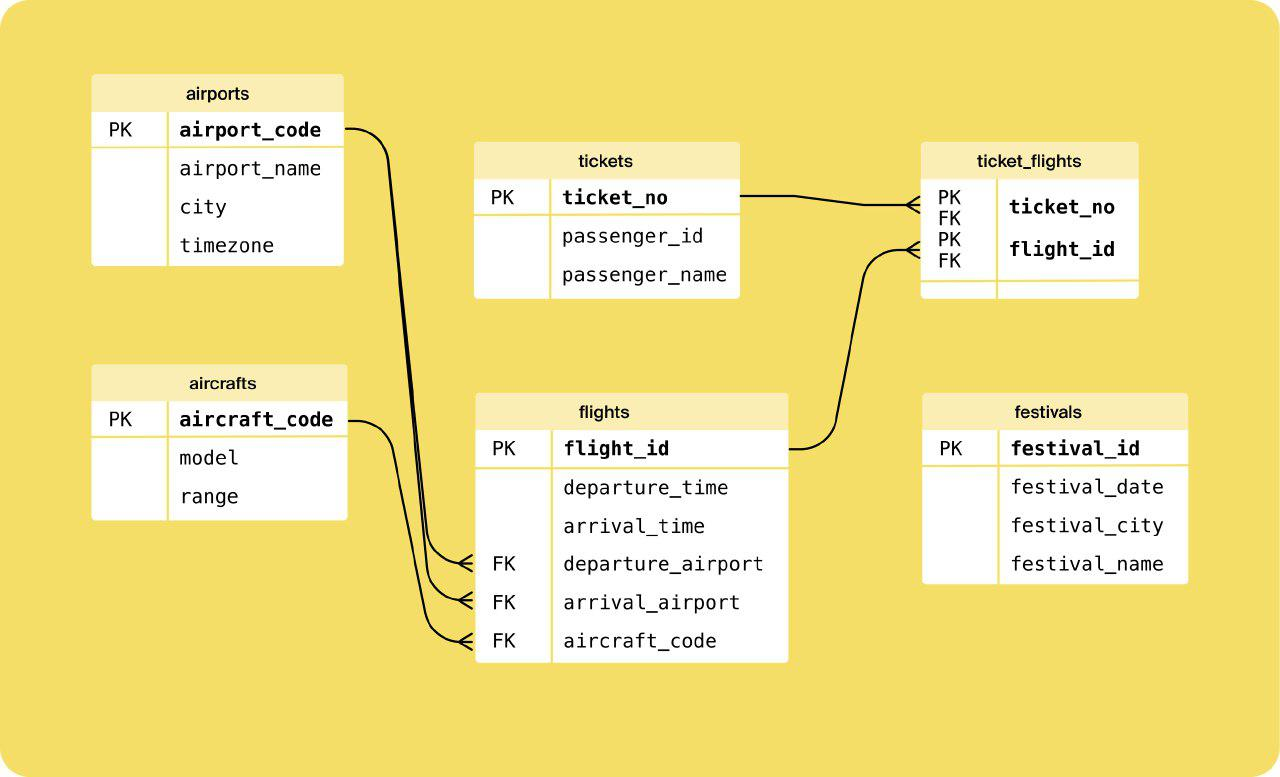

---

1. Список городов `city`, в которых есть аэропорты.

```SQL
SELECT
    DISTINCT city from airports;
```

Результат:

|CITY	        |
|---------------|
|Липецк	        |
|Оренбург       |
|Южно-Сахалинск |
|Красноярск     |
|Калуга         |
|. . .	        |

---

2. Количество вылетов `flight_id` из каждого аэропорта вылета `departure_airport`, в порядке убывания количества вылетов.

```SQL
SELECT 
    departure_airport, COUNT(flight_id) AS cnt_flights
FROM 
    flights
GROUP BY 
    departure_airport
ORDER BY 
    cnt_flights DESC;
```

Результат:

|DEPARTURE_AIRPORT |CNT_FLIGHTS	|
|------------------|------------|
|DME               |6376        |
|SVO               |5912        |
|LED               |3769        |
|VKO               |3405        |
|OVB               |2091        |
|. . .             |. . .       |

---

3. Количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года. 

```SQL
SELECT 
    aircrafts.model AS model,
    COUNT(flights.aircraft_code) AS flights_amount
FROM 
    flights
    LEFT JOIN aircrafts ON aircrafts.aircraft_code = flights.aircraft_code
WHERE
    extract(month FROM departure_time) = 9
GROUP BY 
    model;
```

Результат:

|MODEL	                |FLIGHTS_AMOUNT |
|-----------------------|---------------|
|Airbus A319-100	    | 607           |
|Airbus A321-200	    | 960           |
|Boeing 737-300	        | 630           |
|Boeing 767-300	        | 600           |
|Boeing 777-300	        | 300           |
|Bombardier CRJ-200	    | 4446          |
|Cessna 208 Caravan	    | 4557          |
|Sukhoi SuperJet-100	| 4185          |

---

4. Количество рейсов по всем моделям самолетов `Boeing` и `Airbus` в сентябре. 

```SQL           
SELECT 
    COUNT(flights.aircraft_code) AS flights_amount
FROM 
    flights
    LEFT JOIN aircrafts ON aircrafts.aircraft_code = flights.aircraft_code
WHERE 
    extract(month FROM departure_time) = 9 AND aircrafts.model LIKE 'Airbus%'

UNION
           
SELECT
    COUNT(flights.aircraft_code) AS flights_amount
FROM
    flights
    LEFT JOIN aircrafts ON aircrafts.aircraft_code = flights.aircraft_code
WHERE 
    extract(month FROM departure_time) = 9 AND aircrafts.model LIKE 'Boeing%';
```

Результат:

|FLIGHTS_AMOUNT |
|---------------|
| 1530          |
| 1567          |

---

5. Среднее количество прибывающих рейсов в день для каждого города за август 2018 года.    

```SQL          
SELECT
    flights_count.city AS city,
    AVG(flights_count.flights_cnt) AS average_flights
FROM
    (
    SELECT
        airports.city AS city,
        extract(day FROM flights.arrival_time) AS days,
        COUNT(flights.flight_id) AS flights_cnt
    FROM
        flights
        LEFT JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE 
        extract(month FROM departure_time) = 8
    GROUP BY
        city,
        days  
    ) AS flights_count  
GROUP BY
   flights_count.city;
```   

Результат:

|CITY         |AVERAGE_FLIGHTS	|
|-------------|-----------------|
|Абакан       |3.87097          |
|Анадырь      |1.05556          |
|Анапа        |2.16129          |
|Архангельск  |5.35484          |
|Астрахань    |2.45161          |
|. . .        |. . .            |

---

6. Фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. 

```SQL
SELECT
    festival_name,
    extract(week FROM festival_date) AS festival_week
FROM
    festivals
WHERE
    festival_city = 'Москва' AND
    festival_date::date BETWEEN '2018-07-23' AND '2018-09-30';
```

Результат:

|FESTIVAL_NAME|	FESTIVAL_WEEK |
|-------------|---------------|
|Park Live	  |      30       |
|Пикник Афиши |    31         |
|Видфест	  |          36   |

---

7. Количество билетов, купленных на рейсы в Москву для каждой недели с 23 июля по 30 сентября 2018 года; отметка, проходил ли в эту неделю фестиваль; название фестиваля `festival_name` и номер недели `week_number`.

```SQL
SELECT
    week_ticket.week AS week_number,
    week_ticket.ticket_amount AS ticket_amount,
    festival_sel.festival_week AS festival_week,
    festival_sel.festival_name

FROM
    (   
    SELECT 
        extract(week FROM flights.arrival_time) AS week,
        COUNT(ticket_flights.ticket_no) AS ticket_amount
    FROM
        flights
        INNER JOIN ticket_flights ON ticket_flights.flight_id =  flights.flight_id
    WHERE
        flights.arrival_time::date BETWEEN '2018-07-23' AND '2018-09-30' AND
        arrival_airport IN (SELECT airport_code FROM airports WHERE city = 'Москва') 
    GROUP BY
        week
    ) AS week_ticket
    
LEFT JOIN
    (
    SELECT
        festival_name,
        extract(week FROM festival_date) AS festival_week
    FROM
        festivals
    WHERE
        festival_city = 'Москва' AND
        festival_date::date BETWEEN '2018-07-23' AND '2018-09-30'
    ) AS festival_sel

ON festival_sel.festival_week = week_ticket.week

ORDER BY
    week;
```

Результат:

|WEEK_NUMBER|TICKET_AMOUNT|FESTIVAL_WEEK|FESTIVAL_NAME|
|-----------|-------------|-------------|-------------|
|30	        |  43568	  |        30	|   Park Live |
|31	        |  51034	  |        31	|Пикник Афиши |
|32	        |  51675	  |        nan	|             |
|33	        |  51378	  |        nan	|             |
|34	        |  51492	  |        nan	|             |
|35	        |  51360	  |        nan	|             |
|36	        |  51386	  |        36	|Видфест      |
|37	        |  51670	  |        nan	|             |
|38	        |  51518	  |        nan	|             |
|39	        |  51623	  |        nan	|             |

## 3. Обработка данных средствами Python

### 3.1 Предобработка данных

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

pd.set_option('display.max_rows', 11)

path = 'C:/Users/pavel/Desktop/da/projects/datasets/'

In [5]:
# датасет из 3-го SQL-запроса (количество рейсов для каждой модели самолета)
models = pd.read_csv(path + '06_sql_query_3.csv')

В `models` содержится следующая информация:
- `model` — модель самолета;
- `flights_amount` — количество рейсов для каждой модели самолета в сентябре 2018 года.

In [6]:
models

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [7]:
# выведем типы данных и количество записей в датасете
models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


---

In [8]:
# датасет из 5-го SQL-запроса (среднее количество рейсов для города)
avg_arrival_flights = pd.read_csv(path + '06_sql_query_5.csv')

В `avg_arrival_flights` содержится следующая информация:
- `city` — город;
- `average_flights` — среднее количество рейсов, прибывающих в город за день в сентябре 2018 года.

In [9]:
avg_arrival_flights

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


In [10]:
# выведем типы данных и количество записей в датасете
avg_arrival_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [11]:
# количество полных дубликатов в столбце город
avg_arrival_flights['city'].duplicated().sum()

0

Данные извлечены корректно, без пропусков, неправильных типов и дубликатов.

### 3.2 Исследовательский анализ данных   
Рассмотрим имеющиеся данные более подробно.

In [12]:
# зададим функцию для отображения значений на графиках 
# (h_v - горизонтальный или вертикальный график,
# space - расстояние от вершины столбца графика до числа
# decimal - порядок округления числа)
def _show_values_on_bars(ax, h_v = "v", space = 0.4, decimal = 0):
    if h_v == "v":
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + float(space)
            if decimal == 0:
                value = int(p.get_height())
            else:
                value = round(p.get_height(), decimal)
            ax.text(_x, _y, value, ha = "center")
    elif h_v == "h":
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            if decimal == 0:
                value = int(p.get_width())
            else:
                value = round(p.get_width(), decimal)
            ax.text(_x, _y, value, ha="left")

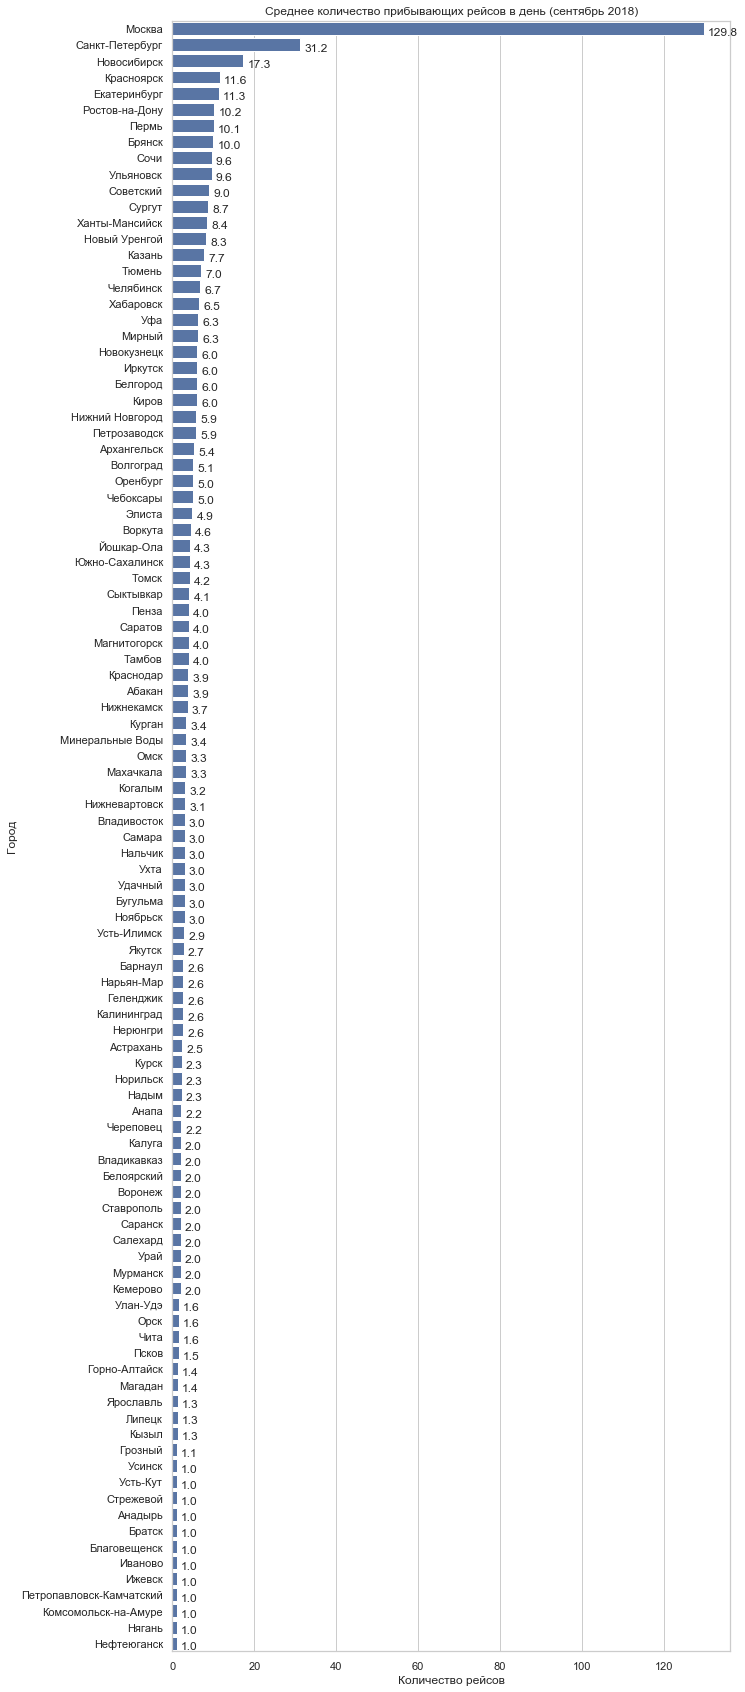

In [13]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# среднее количество прибывающих рейсов в день для каждого города
sns.barplot(y = "city", x = "average_flights", 
            data=avg_arrival_flights.sort_values('average_flights', ascending = False),
            color = "b")

ax.set(xlabel = 'Количество рейсов', ylabel = 'Город', 
       title = 'Среднее количество прибывающих рейсов в день (сентябрь 2018)')

_show_values_on_bars(ax, 'h', 1, 1)
plt.show()

In [14]:
# топ-10 городов по количеству рейсов в день
avg_arrival_flights.sort_values('average_flights', ascending = False).head(10)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


В сентябре 2018 года только в 8 городах из всего списка выбранных (101) в среднем прибывает по 10 и больше рейсов в день. Причем в Москву прибывает столько же рейсов, сколько во все остальные города топ-11 (по количеству рейсов) вместе взятые.

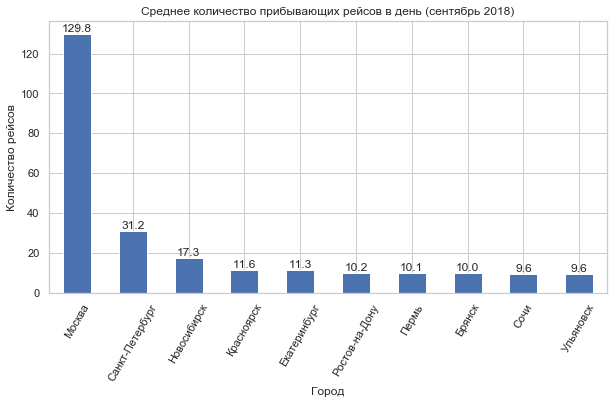

In [15]:
# топ-10 городов по среднему количеству прибывающих рейсов в день  
ax = avg_arrival_flights.sort_values('average_flights', ascending = False).head(10)\
.plot(x = 'city', kind = 'bar', legend = False, grid = True, figsize = (10,5))

_show_values_on_bars(ax, 'v', 1, 1)  

ax.set(xlabel = 'Город', ylabel = 'Количество рейсов', 
       title = 'Среднее количество прибывающих рейсов в день (сентябрь 2018)')    

plt.xticks(rotation = 60)
plt.show()

---

Рассмотрим количество рейсов, совершенных на разных моделях самолетов. 

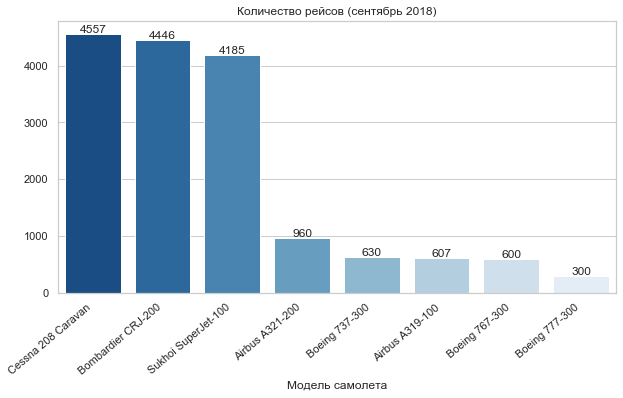

In [16]:
f, ax = plt.subplots(figsize=(10, 5))

# количество рейсов для каждой модели самолета 
ax = sns.barplot(x = "model", y = "flights_amount",
                 data = models.sort_values('flights_amount', ascending = False), palette = "Blues_r")

ax.set(xlabel = 'Модель самолета', ylabel = '',
       title = 'Количество рейсов (сентябрь 2018)')

_show_values_on_bars(ax, 'v', 20)

plt.xticks(rotation = 40, horizontalalignment = 'right')
plt.show()

В сентябре 2018 года больше всего авиарейсов было совершено на моделях самолетов:
- Cessna 208 Caravan;
- Bombardier CRJ-200;
- Sukhoi SuperJet-100,

на всех остальных моделях было совершено намного меньше (как минимум в 4 раза) рейсов. 

### 3.3 Проверка гипотезы
Рассмотрим, как изменялась активность пассажиров (количество проданных билетов) во время проведения фестивалей.

In [17]:
# датасет из 7-го SQL-запроса (количество проданных билетов в каждую неделю)
tickets = pd.read_csv(path + '06_sql_query_7.csv', index_col=0)

В `tickets` содержится следующая информация:
- `week_number` — номер недели;
- `ticket_amount` — количество проданных билетов за неделю;
- `festival_week` — есть ли на этой неделе фестиваль (номер недели - если есть; NaN - если нет);
- `festival_name` — название фестиваля.

In [18]:
tickets

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Рассмотрим количественные характеристики распределений для двух наборов данных: количество проданных билетов за неделю для тех недель, когда были фестивали, и когда их не было. 

In [19]:
# количество проданных билетов в недели без фестивалей
tickets[tickets['festival_week'].isna()].ticket_amount.describe().round(1)

count        7.0
mean     51530.9
std        130.9
min      51360.0
25%      51435.0
50%      51518.0
75%      51646.5
max      51675.0
Name: ticket_amount, dtype: float64

In [20]:
# количество проданных билетов в недели с фестивалями
tickets[~tickets['festival_week'].isna()].ticket_amount.describe().round(1)

count        3.0
mean     48662.7
std       4415.6
min      43568.0
25%      47301.0
50%      51034.0
75%      51210.0
max      51386.0
Name: ticket_amount, dtype: float64

Сформулируем нулевую гипотезу: 

среднее количество проданных билетов в Москву в те недели, когда там проходили фестивали равно среднему количеству проданных билетов в остальное время (в пределах ограничения по дате: 23 июля - 30 сентября 2018).

In [21]:
# зададим уровень статистической значимости в 5%
alpha = .05 

# поскольку дисперсии (и стандартные отклонения) для двух наборов не равны,
# изменим значение параметра equal_var, установленное по умолчанию
results = st.ttest_ind(tickets[tickets['festival_week'].isna()].ticket_amount, 
                       tickets[~tickets['festival_week'].isna()].ticket_amount, 
                       equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 0.377432493172683


Уровень статистической значимости выше критического. Нет оснований, чтобы отвергнуть нулевую гипотезу.

С вероятностью ~38% среднее количество проданных билетов в недели без фестивалей равно среднему количеству билетов проданных в остальное время.

## 4. Выводы

1. Города с наибольшим количеством прибывающих авиарейсов в день в сентябре 2018 года: Москва, Санкт-Петербург, Новосибирск. 
2. Модели самолетов с наибольшим количеством совершенных авиарейсов: Cessna 208 Caravan, Bombardier CRJ-200, Sukhoi SuperJet-100.
3. Среднее количество проданных авиабилетов в Москву за неделю не зависит от проведения там фестиваля. 